# Problem Set 1, Question 1

In this problem, you will interact with this provided python notebook to explore the Bayes-optimal decision surface when the conditional distributions of $x$ given $y$ are normally distributed.

Please read through and execute the cells below.

<div class="alert alert-info">At the end of the notebook are free-response questions in boxes like this.  You should provide your answer in the subsequent cell.</div>

## Mathematical model

Before presenting the code, here is the set up:

- We are looking at a classiciation problem with two classes: $y=A$ and $y=B$
- There are two real-valued features (i.e., $x$ is a 2d vector) --- although this analysis extends naturally to higher dimensions
- We are interested in the Bayes-optimal classifier and therefore assume that all of the distributions are known (i.e., they do not need to be estimated from data)
- The prior class distributions can be described by a pair of numbers that sum to 1: $p(y=A)$ and $p(y=B)$
- Given the class, the distribution over the features is a normal distribution (a "Gaussian"):
\begin{align*}
p(x\mid y=A) &= \frac{1}{\sqrt{2\pi}\sigma}e^{-(x-\mu_A)^\top (x-\mu_A)/(2\sigma^2)} \\
p(x\mid y=B) &= \frac{1}{\sqrt{2\pi}\sigma}e^{-(x-\mu_B)^\top (x-\mu_B)/(2\sigma^2)}
\end{align*}

- Note that the means (centers) of the normal distributions are different for each class ($\mu_A$ versus $\mu_B$), but that both distributions share the same standard deviation ($\sigma$)


In [1]:
# The imports necessary to do the calculations and plotting
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.gridspec as gridspec

mycm = cm.jet
#%matplotlib notebook

### Let's first define the normal probability density function:

In [2]:
def normalpdf(x,mu,sigma): #高斯p(x|y=?)
    return 1.0/(np.sqrt(2*np.pi)*sigma)*np.exp(-((x-mu).dot(x-mu))/(2*sigma*sigma))

### Now some functions to do plotting

In [3]:
def fntoXYZ(minx,maxx,fn,ndiv): #返回点坐标
    # evaluates function fn on a grid of points and returns 
    # arrays of the X-values, Y-values, and Z-values (z is from fn) for these points
    X,Y = np.meshgrid(np.linspace(minx[0],maxx[0],ndiv),np.linspace(minx[1],maxx[1],ndiv))
    Z = np.zeros(X.shape)
    for x,y,z in np.nditer([X,Y,Z],[],['readwrite']):
        z[...] = fn(np.array([x,y]))
    return X,Y,Z

In [4]:
def plotsurfandcont(minx,maxx,fn,ndiv,ax,lvls=None,clrs=None): #3d图
    # plots the function fn and its contours over the rectangle defined by minx and maxx
    # ndiv is the size of the grid, ax is the matplotlib axes to use,
    # lvls are the contour levels and clrs are the contour colors
    X,Y,Z = fntoXYZ(minx,maxx,fn,ndiv)
    if lvls is None:
        surf = ax.plot_surface(X,Y,Z,cmap=mycm,alpha=0.5)
    else:
        surf = ax.plot_surface(X,Y,Z,cmap=mycm,alpha=0.5,vmin=lvls[0],vmax=lvls[-1])
    
    if lvls is None:
        cont = ax.contour(X,Y,Z)
    else:
        if clrs is None:
            cont = ax.contour(X,Y,Z,lvls)
        else:
            cont = ax.contour(X,Y,Z,lvls,colors=clrs)
    return surf, cont

In [5]:
def plotcontonly(minx,maxx,fn,ndiv,ax,lvls=None,clrs=None): #2d图
    # As plotsurfandcont, but only plots the contours (thus a 2d plot only)
    X,Y,Z = fntoXYZ(minx,maxx,fn,ndiv)
    if lvls is None:
        cont = ax.contour(X,Y,Z)
    else:
        if clrs is None:
            cont = ax.contour(X,Y,Z,lvls)
        else:
            cont = ax.contour(X,Y,Z,lvls,colors=clrs)
    return cont

In [6]:
def getlvlandclr(minx,maxx,fn1,fn2,ndiv): 
    # Find a set of contour levels and colors that work for two plots
    X,Y,Z1 = fntoXYZ(minx,maxx,fn1,ndiv)
    X,Y,Z2 = fntoXYZ(minx,maxx,fn2,ndiv)
    maxz = max(Z1.max(),Z2.max())
    minz = min(Z1.min(),Z2.min())
    lvls = np.linspace(minz,maxz,10)
    clrs = [mycm(x) for x in np.linspace(0,1,10)]
    return lvls,clrs

In [7]:
def plot2fns(minx,maxx,fn1,fn2): #放置两图
    # plots two functions on the same plot, both as 3d plots and 2d contours
    
    # not efficient, as it calculates Z from X,Y multiple times
    plt.gcf().set_size_inches(9,6)
    
    ndiv = 50
    
    lvls,clrs = getlvlandclr(minx,maxx,fn1,fn2,ndiv)
        
    gs = gridspec.GridSpec(1,2,width_ratios=[2,1])
    ax1 = plt.gcf().add_subplot(gs[0,0],projection='3d')
    surf1,cont1 = plotsurfandcont(minx,maxx,fn1,ndiv,ax1,lvls,clrs)
    surf2,cont2 = plotsurfandcont(minx,maxx,fn2,ndiv,ax1,lvls,clrs)
    ax1.set_aspect('equal','box')
    ax1.set_xlabel('$x_1$')
    ax1.set_ylabel('$x_2$')
    
    ax2 = plt.gcf().add_subplot(gs[0,1])
    cont1b = plotcontonly(minx,maxx,fn1,ndiv,ax2,lvls,clrs)
    cont2b = plotcontonly(minx,maxx,fn2,ndiv,ax2,lvls,clrs)
    ax2.set_aspect('equal','box')
    ax2.axis([minx[0],maxx[0],minx[1],maxx[1]])
    ax2.set_xlabel('$x_1$')
    ax2.set_ylabel('$x_2$')
    
    plt.subplots_adjust(left=0,bottom=0,right=0.95,top=1,wspace=0.2,hspace=0.1)

## Parameters to our problem:

Now we get to our problem.

This initial set up ($\mu_A = [1,1]$, $\mu_B = [-3,-1]$, $\sigma=2$, $p(y\!\!=\!\!A) = 0.3$, $p(y\!\!=\!\!B)=0.7$) is provided to show you how this works.  

This means that each point has a 30% chance of being class A and a 70% chance of being class B.  If the point is class A, then the features are drawn from a normal distribution centered at the point $[1,1]$.  If class B, the center of the feature distribution is $[-3,-1]$.  In each case the "spread" of the features (standard deviation) is $2$.

You should change these parameters and the re-execute the subsequent cells to see how things change.

In [8]:
muA = np.array([1.0,1.0]) # mean of p(x|y=A)
muB = np.array([-3.0,-1.0]) # mean of p(x|y=B)
sigma = 2.0 # for both normal distributions

pA = 0.3 # prior distribution over the two classes (y=A and y=B)
pB = 1-pA

### Now we define the probabilities (conditionals, marginals, and joints) as functions of x:

In [9]:
px_A = lambda x : normalpdf(x,muA,sigma) # this is p(x | y=A)
px_B = lambda x : normalpdf(x,muB,sigma) # this is p(x | y=B)

pxA = lambda x : px_A(x)*pA # this is p(x,y=A)
pxB = lambda x : px_B(x)*pB # this is p(x,y=B)

px = lambda x : pxA(x) + pxB(x) # this is p(x) = p(x,y=A)+p(x,y=B)

pA_x = lambda x : px_A(x) * pA / px(x) # this is p(y=A | x)
pB_x = lambda x : px_B(x) * pB / px(x) # this is p(y=B | x)

minpt = [-3,-3]
maxpt = [3,3]

## Below are the results, plotting different distributions

Spend time understanding each plot: what they are plotting and how they are different?

### The conditional distributions of x ***given*** each of the two classes
$p(x\mid y=A)$ and $p(x\mid y=B)$

Recall that these are the original specifications of the distribution over features for each of the two classes, separately

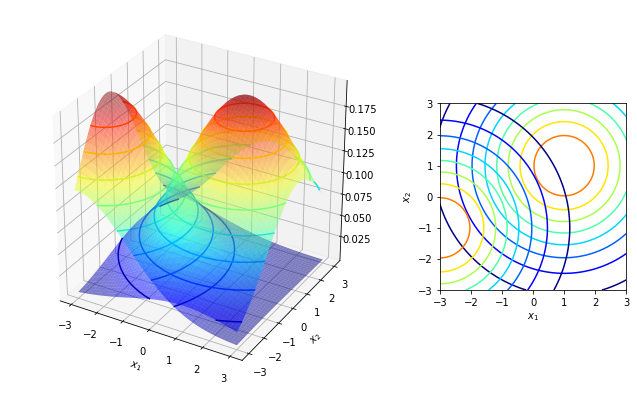

In [10]:
plot2fns(minpt,maxpt,px_A,px_B)

### The distributions of x ***and*** the classes
$p(x,y=A)$ and $p(x,y=B)$

Recall that these are the conditional distributions from the previous plot, but now multiplied by the prior probabilities of each class.

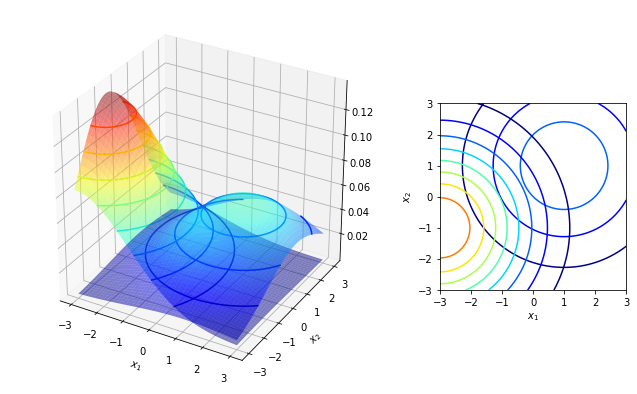

In [11]:
plot2fns(minpt,maxpt,pxA,pxB)

### The conditional distributions of the class, given the point x

$p(y=A\mid x)$ and $p(y=B\mid x)$

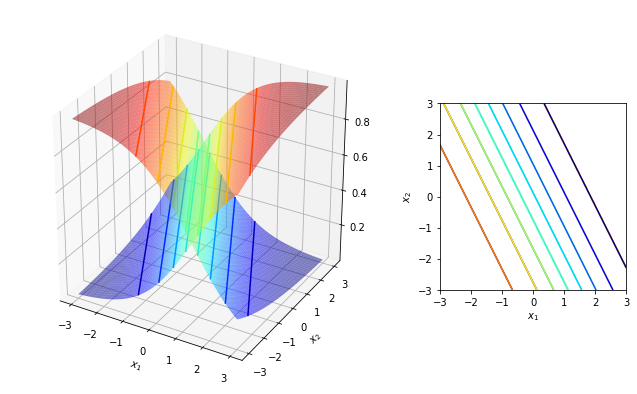

In [12]:
plot2fns(minpt,maxpt,pA_x,pB_x)

These are the probabilities used for making an optimal decision.  When $p(y\!\!=\!\!A\mid x) > p(y\!\!=\!\!B\mid x)$ for a given $x$, the optimal decision is class $A$ (and class $B$ if the inequality goes the other way).  This means that when $p(y\!\!=\!\!A\mid x) = p(y\!\!=\!\!B\mid x)$, we are right on the edge between the two classes.  This is the class decision boundary.

We can plot this directly below.

Where the plot is green, the Bayes-optimal decision is to pick class A.  Where the plot is blue, the choice is class B.  The line inbetween is the decision surface.

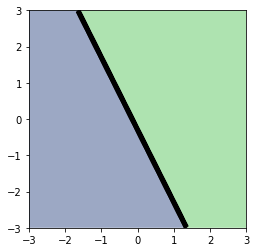

In [13]:
f = lambda x : 1 if pA_x(x)>0.5 else -1
X,Y,Z = fntoXYZ(minpt,maxpt,f,200)
plt.contourf(X,Y,Z,[-2, 0, 2],alpha=0.5,antialiased=True)
plt.contour(X,Y,Z,[-2,0,-2],colors='k',linewidths=5.0,antialiased=True)
plt.gca().set_aspect('equal')

<div class="alert alert-info">
<font size=5>Part (a) Show that this decision boundary must be a line (2 pts)</font>

To do this, you'll need to show that the solutions of $p(y=A\mid x) = p(y=B\mid x)$ are a line.
</div>

## Place your answer here

(here's some of the relevant equations to get you started):

\begin{align*}
p(x\mid y=A) &= \frac{1}{\sqrt{2\pi}\sigma}e^{-(x-\mu_A)^\top(x-\mu_A)/(2\sigma^2)} \\
p(x\mid y=B) &= \frac{1}{\sqrt{2\pi}\sigma}e^{-(x-\mu_B)^\top(x-\mu_B)/(2\sigma^2)} \\
p(y=A) &= p_A \\
p(y=B) &= p_B
\end{align*}

### Your solutions here
We have
\begin{align*}
p(y=A\mid x) &= \frac{p_{A} p(x\mid y=A)}{p_{A} p(x\mid y=A) + p_{B} p(x\mid y=B)} \\
p(y=B\mid x) &= \frac{p_{B} p(x\mid y=B)}{p_{B} p(x\mid y=A) + p_{B} p(x\mid y=B)}.
\end{align*}
In order to have $p(y=A\mid x)$ $=$ $p(y=B\mid x)$,
\begin{align}
\Leftarrow p_{A} p(x\mid y=A) = p_{B} p(x\mid y=B)
\end{align}
\begin{align}
\because p(x\mid y=A) &= \frac{1}{\sqrt{2\pi}\sigma}e^{-(x-\mu_A)^\top(x-\mu_A)/(2\sigma^2)}  \\
p(x\mid y=B) &= \frac{1}{\sqrt{2\pi}\sigma}e^{-(x-\mu_B)^\top(x-\mu_B)/(2\sigma^2)}
\end{align}
\begin{align}
\Rightarrow p_{A} \frac{1}{\sqrt{2\pi}\sigma}e^{-(x-\mu_A)^\top(x-\mu_A)/(2\sigma^2)} = p_{B} \frac{1}{\sqrt{2\pi}\sigma}e^{-(x-\mu_B)^\top(x-\mu_B)/(2\sigma^2)} \\
p_{A} e^{-(x-\mu_A)^\top(x-\mu_A)/(2\sigma^2)} = p_{B} e^{-(x-\mu_B)^\top(x-\mu_B)/(2\sigma^2)}. \\
\end{align}
\begin{align}
\because x-\mu_A &= \begin{bmatrix} x_{1}-\mu_{A1} \\ x_{2}-\mu_{A2} \end{bmatrix} \\
x-\mu_B &= \begin{bmatrix} x_{1}-\mu_{B1} \\ x_{2}-\mu_{B2} \end{bmatrix},
\end{align}
\begin{align}
\therefore(x-\mu_A)^\top(x-\mu_A) &= (x_{1}-\mu_{A1})^2+(x_{2}-\mu_{A2})^2 \\
(x-\mu_B)^\top(x-\mu_B) &= (x_{1}-\mu_{B1})^2+(x_{2}-\mu_{B2})^2
\end{align}
\begin{align}
\therefore p_{A}\exp{\frac{-(x_{1}-\mu_{A1})^2-(x_{2}-\mu_{A2})^2}{2\sigma^2}} &= p_{B}\exp{\frac{-(x_{1}-\mu_{B1})^2-(x_{2}-\mu_{B2})^2}{2\sigma^2}}
\end{align}
\begin{align}
\ln{p_{A}\exp{\frac{-(x_{1}-\mu_{A1})^2-(x_{2}-\mu_{A2})^2}{2\sigma^2}}} &= \ln{p_{B}\exp{\frac{-(x_{1}-\mu_{B1})^2-(x_{2}-\mu_{B2})^2}{2\sigma^2}}} \\
\ln{p_{A}} + \frac{-(x_{1}-\mu_{A1})^2-(x_{2}-\mu_{A2})^2}{2\sigma^2} &= \ln{p_{B}} + \frac{-(x_{1}-\mu_{B1})^2-(x_{2}-\mu_{B2})^2}{2\sigma^2} \\
\end{align}
\begin{align}
2\sigma^2\ln{\frac{p_{A}}{p_{B}}}+2(x_1\mu_{A1}+x_2\mu_{A2}-x_1\mu_{B1}-x_2\mu_{B2})-(\mu_{A1}^2+\mu_{A2}^2)+(\mu_{B1}^2+\mu_{B2}^2) &= 0
\end{align}

When $p_A=0.3$, $p_B=0.7$, $\sigma=2.0$, $\mu_A=[1.0, 1.0]$, $\mu_B=[-3.0, -1.0]$, the formula equals to
\begin{align}
2\ln{\frac{3}{7}}+2x_1+x_2+2=0,
\end{align}
which is a equation for line.

<div class="alert alert-info">
<font size=5>Part (b) What happens to the line in each of the following situations? (3 pts)</font>

i. The means, $\mu_A$ and $\mu_B$, change.<br>
ii. The standard deviation, $\sigma$, changes.<br>
iii. The prior probabilities, $p(y\!\!=\!\!A)$ and $p(y\!\!=\!\!B)$, change.
</div>

## Place your answers here


i. The means, $\mu_A$ and $\mu_B$, change.
- If one of (or both) $\mu_A$'s and $\mu_B$'s values were increased, the line moves to its right; the slope gets lower if $\mu_{A1}$ or $\mu_{B2}$ increased more (measured by proportion) than $\mu_{A2}$ or $\mu_{B1}$, otherwise it gets higher.
- If one of (or both) $\mu_A$'s and $\mu_B$'s values were decreased, the line moves to its left; the slope gets higher if $\mu_{A1}$ or $\mu_{B2}$ decreased more (measured by proportion) than $\mu_{A2}$ or $\mu_{B1}$, otherwise it gets lower.
- If the values for $\mu_A$ and $\mu_B$ change in different directions, it will depend on who changed more (measured by proportion).

ii. The standard deviation, $\sigma$, changes. 
- If $\sigma$ gets higher, the line moves to its right; otherwise it moves to the left.

iii. The prior probabilities, $p(y\!\!=\!\!A)$ and $p(y\!\!=\!\!B)$, change. 
- If $p(y = A)$ increased (and $p(y = B)$ decreased correspondingly), the line moves to its left; otherwise it moves to the right.

In [ ]:
muA = np.array([1.0,1.0]) # CHANGE THE VALUE TO SEE THE CHANGE
muB = np.array([-3.0,-1.0]) # CHANGE THE VALUE TO SEE THE CHANGE
sigma = 2.0 #CHANGE THE VALUE TO SEE THE CHANGE

pA = 0.3 # CHANGE THE VALUE TO SEE THE CHANGE
pB = 1-pA

px_A = lambda x : normalpdf(x,muA,sigma)
px_B = lambda x : normalpdf(x,muB,sigma)

pxA = lambda x : px_A(x)*pA
pxB = lambda x : px_B(x)*pB

px = lambda x : pxA(x) + pxB(x)

pA_x = lambda x : px_A(x) * pA / px(x)
pB_x = lambda x : px_B(x) * pB / px(x)

minpt = [-3,-3]
maxpt = [3,3]

plot2fns(minpt,maxpt,px_A,px_B)
plot2fns(minpt,maxpt,pxA,pxB)
plot2fns(minpt,maxpt,pA_x,pB_x)
f = lambda x : 1 if pA_x(x)>0.5 else -1
X,Y,Z = fntoXYZ(minpt,maxpt,f,200)
plt.contourf(X,Y,Z,[-2, 0, 2],alpha=0.5,antialiased=True)
plt.contour(X,Y,Z,[-2,0,-2],colors='k',linewidths=5.0,antialiased=True)
plt.gca().set_aspect('equal')